# A/B Test Project

You have received an analytical task from an international online store. Your predecessor was unable to complete it: they launched an A/B test and then gave up (to start a watermelon farm in Brazil). They left only the technical specifications and the test results.

## Technical Description

- **Test name:** `recommender_system_test`
- **Groups:** A (control), B (new payment funnel)
- **Start date:** 2020-12-07
- **Date when they stopped receiving new users:** 2020-12-21
- **End date:** 2021-01-01
- **Audience:** 15% of new users from the EU region
- **Purpose of the test:** testing changes related to the introduction of an improved recommendation system
- **Expected result:** within 14 days after registration, users show better conversion in:
  - product page views (`product_page` event)
  - adding items to cart (`product_cart`)
  - purchases (`purchase`)

  At each stage of the funnel `product_page → product_cart → purchase`, there will be at least a 10% increase.

- **Expected number of test participants:** 6000

## Task

Download the test data, check if it was conducted correctly, and analyze the results.

### Data Description

- `ab_project_marketing_events_us.csv` — the marketing event calendar for 2020
- `final_ab_new_users_upd_us.csv` — all users who registered in the online store from December 7 to December 21, 2020
- `final_ab_events_upd_us.csv` — all events from new users during the period from December 7, 2020 to January 1, 2021
- `final_ab_participants_upd_us.csv` — table containing the test participants

**Structure of `ab_project_marketing_events_us.csv`:**

- `name` — the name of the marketing event
- `regions` — the regions where the campaign took place
- `start_dt` — the campaign start date
- `finish_dt` — the campaign end date

**Structure of `final_ab_new_users_upd_us.csv`:**

- `user_id`
- `first_date` — registration date
- `region`
- `device` — the device used for registration

**Structure of `final_ab_events_upd_us.csv`:**

- `user_id`
- `event_dt` — date and time of the event
- `event_name` — name of the event source
- `details` — additional data about the event (for example, the order total in US


### Instructions to Complete the Task

- Describe the objectives of the study.
- Explore the data:
  - Do the data types need to be converted?
  - Are there any missing or duplicate values? If so, how will you characterize them?

In [2]:
#importando as bibliotecas necessárias
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as st
import math 
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest

In [4]:
#reading files

def read_csv(file_name='name.csv'):
    '''
    We are using this function to read files
    '''
    df = pd.read_csv(file_name, sep=',')
    return df

ab_mkt_events = read_csv('ab_project_marketing_events_us.csv')
ab_new_users = read_csv('final_ab_new_users_upd_us.csv')
ab_events = read_csv('final_ab_events_upd_us.csv')
ab_participants = read_csv('final_ab_participants_upd_us.csv')


_Analysing each dataframe_

In [5]:
ab_mkt_events.info()
print()
ab_mkt_events.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes



,name,regions,start_dt,finish_dt
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01


This dataframe consists of 4 columns, containing 14 rows with the name of each event, the region, and its start date.  
There are no missing or duplicate values, but we can confirm this by using the `isna` and `duplicated` methods.

We can convert the date values to `datetime`.

In [6]:
print(f'Null data', ab_mkt_events.isna().sum())
print()
print(f'Duplicated data',ab_mkt_events.duplicated().sum())

Null data name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Duplicated data 0


In [7]:
def convert_time(df, cols):
    '''
    We will use this function to convert the data to `datetime` whenever needed.
    '''
    for col in cols:
        df[col] = pd.to_datetime(df[col])
    return df.sample(5)

In [8]:
convert_time(ab_mkt_events,['start_dt', 'finish_dt'])

ab_mkt_events.info()

ab_mkt_events.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes


,name,regions,start_dt,finish_dt
4,4th of July Promo,N.America,2020-07-04,2020-07-11
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


In [9]:
ab_new_users.info()

ab_new_users.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


,user_id,first_date,region,device
29565,BF5758DC9D7AB7B2,2020-12-16,EU,Android
3770,5B0CA25C762378E6,2020-12-07,EU,iPhone
49919,245BD962FFBC57F0,2020-12-19,N.America,PC
21522,564AC2EFBE8D2847,2020-12-15,EU,Android
42819,CDF6B4FE6A0E6168,2020-12-18,EU,PC


This dataset contains 4 columns and 58,704 rows with user ID data, registration date, region, and the device used for registration.  
Apparently, there are no null or duplicate values, and all columns are objects.  
We can convert the date values to `datetime`.

In [10]:
print(f'Null data', ab_new_users.isna().sum())
print()
print(f'Duplicated data',ab_new_users.duplicated().sum())

Null data user_id       0
first_date    0
region        0
device        0
dtype: int64

Duplicated data 0


In [11]:
convert_time(ab_new_users, ['first_date'])

ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [12]:
ab_events.info()

ab_events.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


,user_id,event_dt,event_name,details
90239,E1159E32EB27E60D,2020-12-18 12:21:18,product_cart,NaN
66490,54B78696954828D2,2020-12-10 10:11:59,product_cart,NaN
66782,BBB4061D3005F91F,2020-12-10 07:52:52,product_cart,NaN
316921,E19AC6E5C305D1B3,2020-12-17 09:13:49,login,NaN
218898,202781464CA63932,2020-12-23 02:05:20,product_page,NaN


This dataset contains 4 columns and 423,762 rows, including user ID, event date, event name, and details.

Apparently, there are missing values.

Let’s check the quantity of missing data and convert the date values to `datetime`.

In [11]:
convert_time(ab_new_users, ['first_date'])

ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [13]:
print(f'Null data', ab_events.isna().sum())
print()
print(f'Duplicated data', ab_events.duplicated().sum())

Null data user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

Duplicated data 0


In the `details` column, there are 363,447 null values.  
Let’s take a closer look at these data to decide which approach to take regarding them.

In [14]:
missing_details = ab_events[ab_events['details'].isna()]

print(f'Missing data rows:', missing_details['event_name'].unique())

Missing data rows: ['product_cart' 'product_page' 'login']


In [15]:
not_missing = ab_events.dropna()

not_missing.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


By applying this filter, we can see that the missing data come from events that are not related to purchases and therefore do not require additional information (such as price, for example).  
Thus, we can fill these values with `0` so that the data are not empty and do not negatively impact the analysis in the future.

In [ ]:
ab_events = ab_events.fillna(0)

print(f'Null data', ab_events.isna().sum())
print()
print(f'Duplicated data',ab_events.duplicated().sum())
print()

Dados nulos user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

Dados duplicados 0



In [16]:
print('Quantity of missing data:', missing_details['user_id'].count())
print(f'Share of total: {(missing_details['user_id'].count()) / (ab_events['user_id'].count()):.1%}')


Quantity of missing data: 363447
Share of total: 85.8%


Let's analyze all the data sets to get a macro view:

In [17]:
print('User Events')
display(ab_events.sample(5))
print()
print('New users')
display(ab_new_users.sample(5))
print()
print('Test participants')
display(ab_participants.sample(5))
print()
print('Marketing Events')
display(ab_mkt_events.sample(5))
print()

User Events


,user_id,event_dt,event_name,details
376990,FD3381AC7E6E14FB,2020-12-22 08:52:22,login,NaN
193307,FE086DAFFDBEB075,2020-12-20 11:37:15,product_page,NaN
161162,95D698601071F761,2020-12-15 09:34:29,product_page,NaN
282470,72E2BD1D940702A0,2020-12-13 07:30:20,login,NaN
152246,707423A96043F800,2020-12-14 20:15:54,product_page,NaN



New users


,user_id,first_date,region,device
20677,6789946619BFC208,2020-12-15,EU,Android
50216,F1331F994344FE31,2020-12-19,CIS,PC
49127,2508307EADE88F17,2020-12-19,EU,Android
39502,72FB9A89D5A7E421,2020-12-11,EU,iPhone
33542,A53EE1B18564A48E,2020-12-10,EU,Android



Test participants


,user_id,group,ab_test
11537,2316A9DAADBCA278,B,interface_eu_test
1503,7963560AC5D4166E,B,recommender_system_test
6504,64D39595B31D9ECE,A,interface_eu_test
6071,7C9225B32EAA5277,B,interface_eu_test
8111,3F930D9D6D1F1262,A,interface_eu_test



Marketing Events


,name,regions,start_dt,finish_dt
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03


#### ETL Conclusion

With the `ab_events` and `ab_participants` dataframes, we will be able to perform a thorough analysis of each group's behavior.  
We need to check if there are participants from group A in group B and vice versa to ensure the integrity of the test.  

Additionally, we will be able to answer whether the funnel stage `product_page → product_cart → purchase` actually had a 10% increase, after separating the groups and analyzing the behavior of new users with the `ab_new_users` dataframe and the behavior of all users during promotional periods with the `ab_mkt_event` dataframe.


### Step 2:
#### - Perform exploratory data analysis:
- Study the conversion rates at different stages of the funnel.
- Are users from both samples present?

Before we start analyzing the data, it is important to check if there are users present in both tests simultaneously.

Let's check how many participants from each group there are in each test, and then check how many participated in both groups and what % of the total number of participants they represent.

In [18]:
ab_verify = ab_participants.groupby(['ab_test', 'group'])['user_id'].count().reset_index()
ab_verify

,ab_test,group,user_id
0,interface_eu_test,A,5467
1,interface_eu_test,B,5383
2,recommender_system_test,A,2747
3,recommender_system_test,B,928


In [18]:
print('Number of unique users:', ab_participants['user_id'].nunique())

ab_duplicated = ab_participants['user_id'].duplicated().sum()

print('Number of participants who took part in both tests:', ab_duplicated)
print(f'How many % do they represent in total: {ab_duplicated / len(ab_participants):.1%}')


Number of unique users: 13638
Number of participants who took part in both tests: 887
How many % do they represent in total: 6.1%


This data represents only 6.1% of our participants. We will eliminate it to ensure the integrity of the results.

In [19]:
ab_participants = ab_participants[~ab_participants['user_id'].duplicated(keep=False)]

print('Number of unique users after eliminating those who participated in both tests:', ab_participants['user_id'].nunique())

Number of unique users after eliminating those who participated in both tests: 12751


Let's filter users who are from EU

In [28]:
eu_ab_new_users = ab_new_users[ab_new_users['region'] == 'EU']

Filtering tests from only 'recommender_system_test

In [26]:
rst_ab_participants = ab_participants[ab_participants['ab_test'] =='recommender_system_test']

Let's count how many users we have left now that we have eliminated other regions and another test:

In [29]:
print(eu_ab_new_users['user_id'].nunique())
print(rst_ab_participants['user_id'].count())

43396
2788


Check start and end dates

In [20]:
print('min date', ab_events['event_dt'].min())
print()
print('max date', ab_events['event_dt'].max())

min date 2020-12-07 00:00:33

max date 2020-12-30 23:36:33


Although the description says that the data is from 12/07/202 to 01/01/2021, the data only goes up to December 30th

We will filter the data so that it is from 14 days after registration.

In [22]:
first_fourteen = ab_events.groupby('user_id')['event_dt'].min().reset_index()
first_fourteen.rename(columns={'event_dt': 'first_date_event'}, inplace=True)

ab_events_14 = ab_events.merge(first_fourteen, on='user_id', how='left')




In [23]:
convert_time(ab_events_14, ['event_dt', 'first_date_event'])

,user_id,event_dt,event_name,details,first_date_event
335244,6644BB24A167AD19,2020-12-19 06:36:42,login,NaN,2020-12-07 19:16:59
317257,125E256140851A14,2020-12-17 22:35:24,login,NaN,2020-12-14 07:06:11
284011,945821BBDF122986,2020-12-13 10:57:44,login,NaN,2020-12-13 10:57:44
391754,7064F7D817BDABCE,2020-12-23 04:04:31,login,NaN,2020-12-17 20:22:30
354167,B6D0310031055653,2020-12-20 14:54:08,login,NaN,2020-12-20 14:54:08


In [24]:
ab_events_14['days_since_first'] = (ab_events_14['event_dt'] - ab_events_14['first_date_event']).dt.days
ab_events_14 = ab_events_14[ab_events_14['days_since_first'] <= 14]

### Study conversion at different stages of the funnel.

Let's start by gathering all the necessary data into a single dataframe.

In [30]:
data = pd.merge(rst_ab_participants , eu_ab_new_users, on='user_id', how='left')
data = pd.merge(data, ab_events_14, on='user_id', how='left')

In [31]:
display(data.sample(2))
print()
print(data.info())

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,first_date_event,days_since_first
4848,FDF5ECE92EFCDEEB,A,recommender_system_test,2020-12-19,EU,Android,2020-12-22 08:33:22,product_cart,NaN,2020-12-19 13:29:46,2
16281,51560FF11CCA1F74,A,recommender_system_test,2020-12-10,EU,PC,2020-12-10 22:13:29,login,NaN,2020-12-10 22:13:29,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17852 entries, 0 to 17851
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           17852 non-null  object        
 1   group             17852 non-null  object        
 2   ab_test           17852 non-null  object        
 3   first_date        16647 non-null  datetime64[ns]
 4   region            16647 non-null  object        
 5   device            16647 non-null  object        
 6   event_dt          17852 non-null  datetime64[ns]
 7   event_name        17852 non-null  object        
 8   details           2348 non-null   float64       
 9   first_date_event  17852 non-null  datetime64[ns]
 10  days_since_first  17852 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(1), object(6)
memory usage: 1.5+ MB
None


Let's calculate the size of the event:

In [32]:
funnel_counts = data.groupby('event_name')['user_id'].size()

funnel_counts = funnel_counts.reindex(['login', 'product_page', 'product_cart', 'purchase'])
funnel_rates = funnel_counts / funnel_counts.iloc[0] * 100

funnel_rates = funnel_rates.map(lambda x: f"{x:.1f}%")
funnel_rates

event_name
login           100.0%
product_page     62.2%
product_cart     30.0%
purchase         29.1%
Name: user_id, dtype: object

And now, let's calculate the percentage at each stage of the funnel:

In [33]:
conversion_steps = {
    'login': funnel_counts['login']/funnel_counts['login'],
    'login -> product_page': funnel_counts['product_page'] / funnel_counts['login'],
    'product_page -> product_cart': funnel_counts['product_cart'] / funnel_counts['product_page'],
    'product_cart -> purchase': funnel_counts['purchase'] / funnel_counts['product_cart']
}

conversion_rates = {k: f"{v*100:.1f}%" for k, v in conversion_steps.items()}
conversion_rates

{'login': '100.0%',
 'login -> product_page': '62.2%',
 'product_page -> product_cart': '48.2%',
 'product_cart -> purchase': '97.1%'}

In [34]:
fig = go.Figure(go.Funnel(
    y=list(conversion_rates.keys()),
    x=[float(v.strip('%')) for v in conversion_rates.values()]
))

fig.show()

With this more in-depth analysis, we can see that 62% of users went to the product page and only 48% of those went to the shopping cart. However, 97% of those who put the product in the cart completed their purchases, which could be a great sign! In total, 30% of consumers completed their purchases, which can also be considered a considerable amount. The existence of a larger funnel in the purchase stage than in the shopping cart stage can be justified by those consumers who go directly to the purchase.

### Is the number of events per user evenly distributed across samples?

Let's start by checking the distribution of events by users according to the test

,event_name,user_id
0,login,2787
1,product_cart,826
2,product_page,1757
3,purchase,850


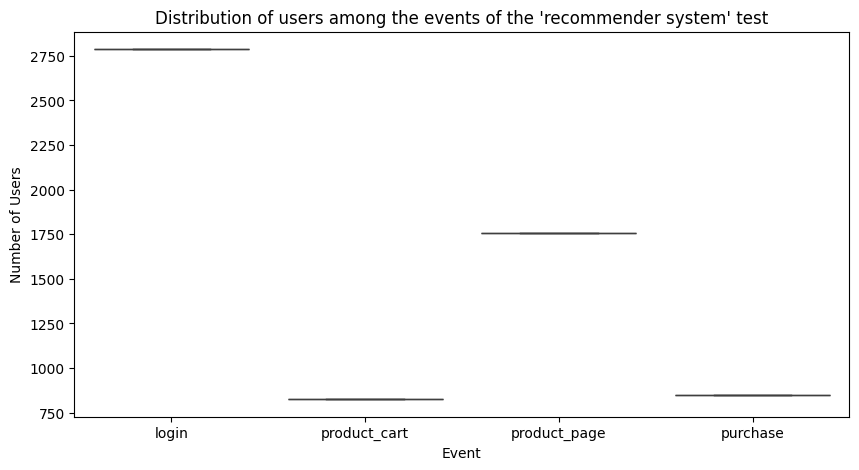

In [35]:
count_user = data.groupby(['event_name'])['user_id'].nunique().reset_index()


display(count_user)
print()

plt.figure(figsize=(10, 5))
sns.boxplot(x='event_name', y='user_id', data=count_user)
plt.xlabel("Event")
plt.ylabel("Number of Users")
plt.title("Distribution of users among the events of the 'recommender system' test")
plt.show()

- The login event is the one that presents the most users, which makes sense since it is a starting point for the website. However, the difference between the next step (which would be product_page) may indicate that many people do not go beyond the login screen, whether due to technical difficulties, complicated login, or forgotten password.
- Just under half of users do not continue to the next screen of product_page
- The difference between the second place may also indicate that the navigation flow is confusing or there is no CTA that takes you to the page, for example.

Now let's check the distribution of events by group

- Let's check the distribution of users by group

In [36]:
count_group = data.groupby('group')['user_id'].nunique().reset_index()

print('Users assigned to "recommender_system_test')
display(count_group)

Users assigned to "recommender_system_test


,group,user_id
0,A,2082
1,B,706


group,A,B
event_name,,
login,2082,705
product_cart,631,195
product_page,1360,397
purchase,652,198


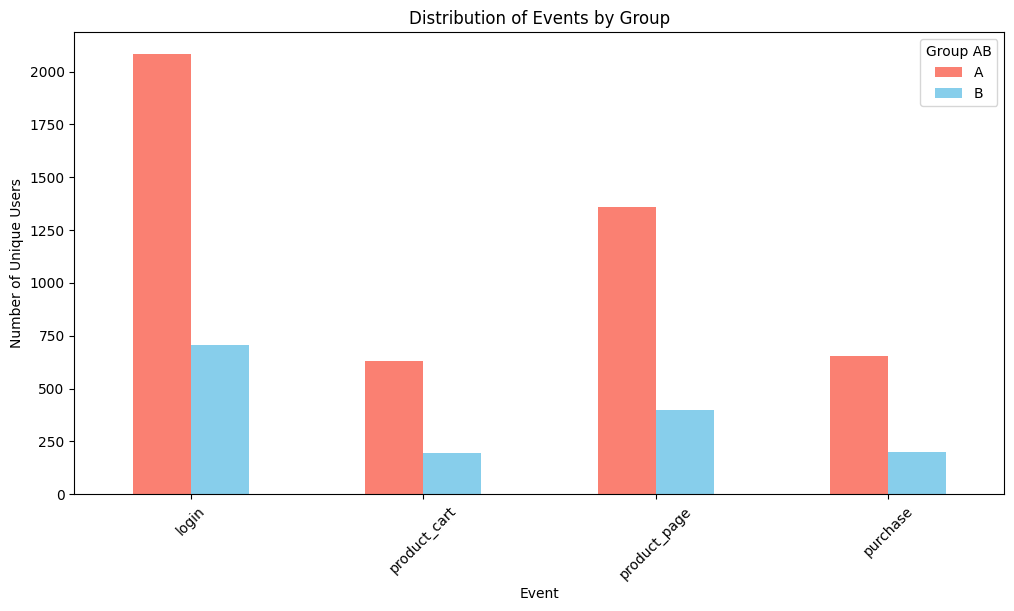

In [37]:
counts_group = pd.pivot_table(data, values='user_id', columns='group', index='event_name', aggfunc='nunique')

display(counts_group)
print()
colors = ['salmon', 'skyblue']
counts_group.plot(kind='bar', figsize=(12, 6), color=colors)
plt.xlabel("Event")
plt.ylabel("Number of Unique Users")
plt.title("Distribution of Events by Group")
plt.xticks(rotation=45)
plt.legend(title="Group AB")
plt.show()

- There was a very small number of users who took part in the 'recommender system' test. The expected number was 6,000 users and we only had 2,787
- Group B of the test represents less than half of the users, which makes the distribution disproportionate

### How is the number of events distributed across days?

Let's create columns for the days and use histplot to check the distribution

In [38]:
data['day'] = data['event_dt'].dt.day_name()
data['hour'] = data['event_dt'].dt.hour
data['event_date'] = data['event_dt'].dt.date

data.sample()


,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,first_date_event,days_since_first,day,hour,event_date
8200,073D8EA132A0CFE2,A,recommender_system_test,2020-12-21,EU,iPhone,2020-12-21 12:42:33,purchase,9.99,2020-12-21 12:42:33,0,Monday,12,2020-12-21


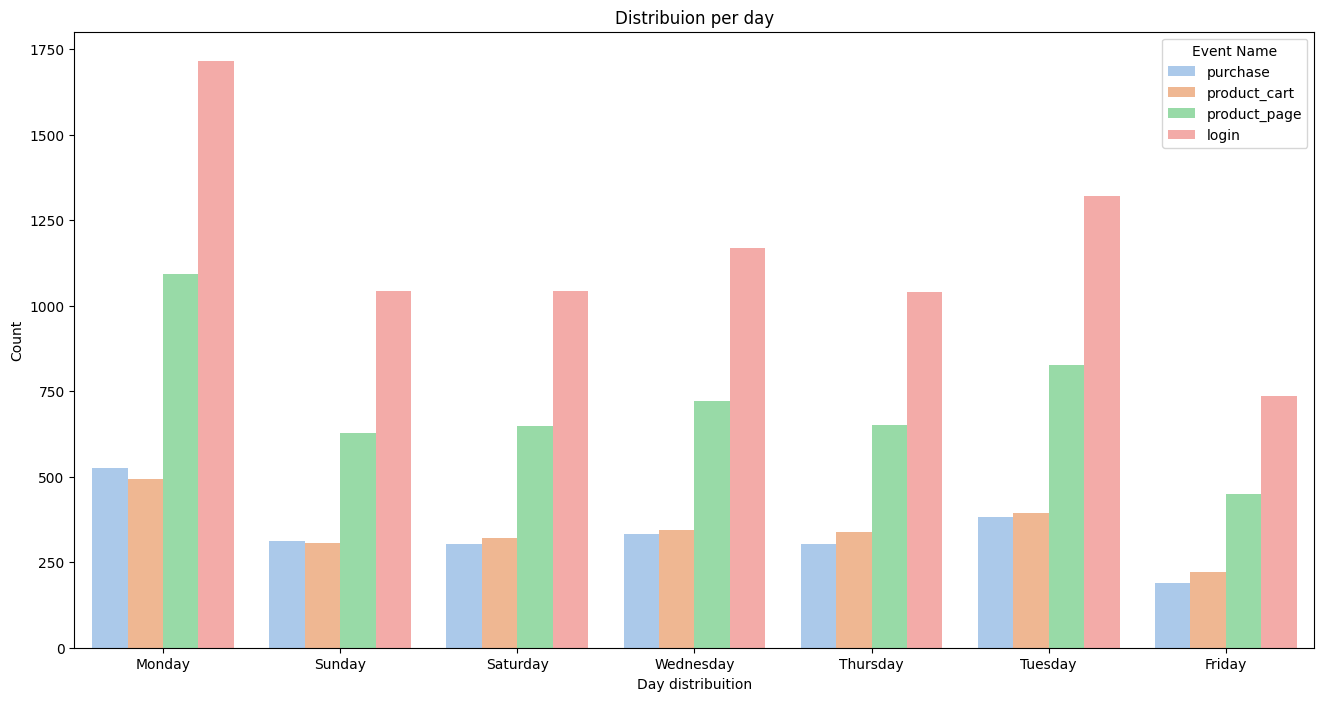

In [40]:
#Distribution per day
plt.figure(figsize=[16,8])
sns.countplot(data, x='day', hue='event_name', palette='pastel')
plt.title('Distribuion per day')
plt.xlabel('Day distribuition')
plt.ylabel('Count')
plt.legend(title="Event Name")
plt.show()

- Monday is the day when the most users logged in, followed by Thursday
- Likewise, the day when the most users purchased was Monday and then Thursday.

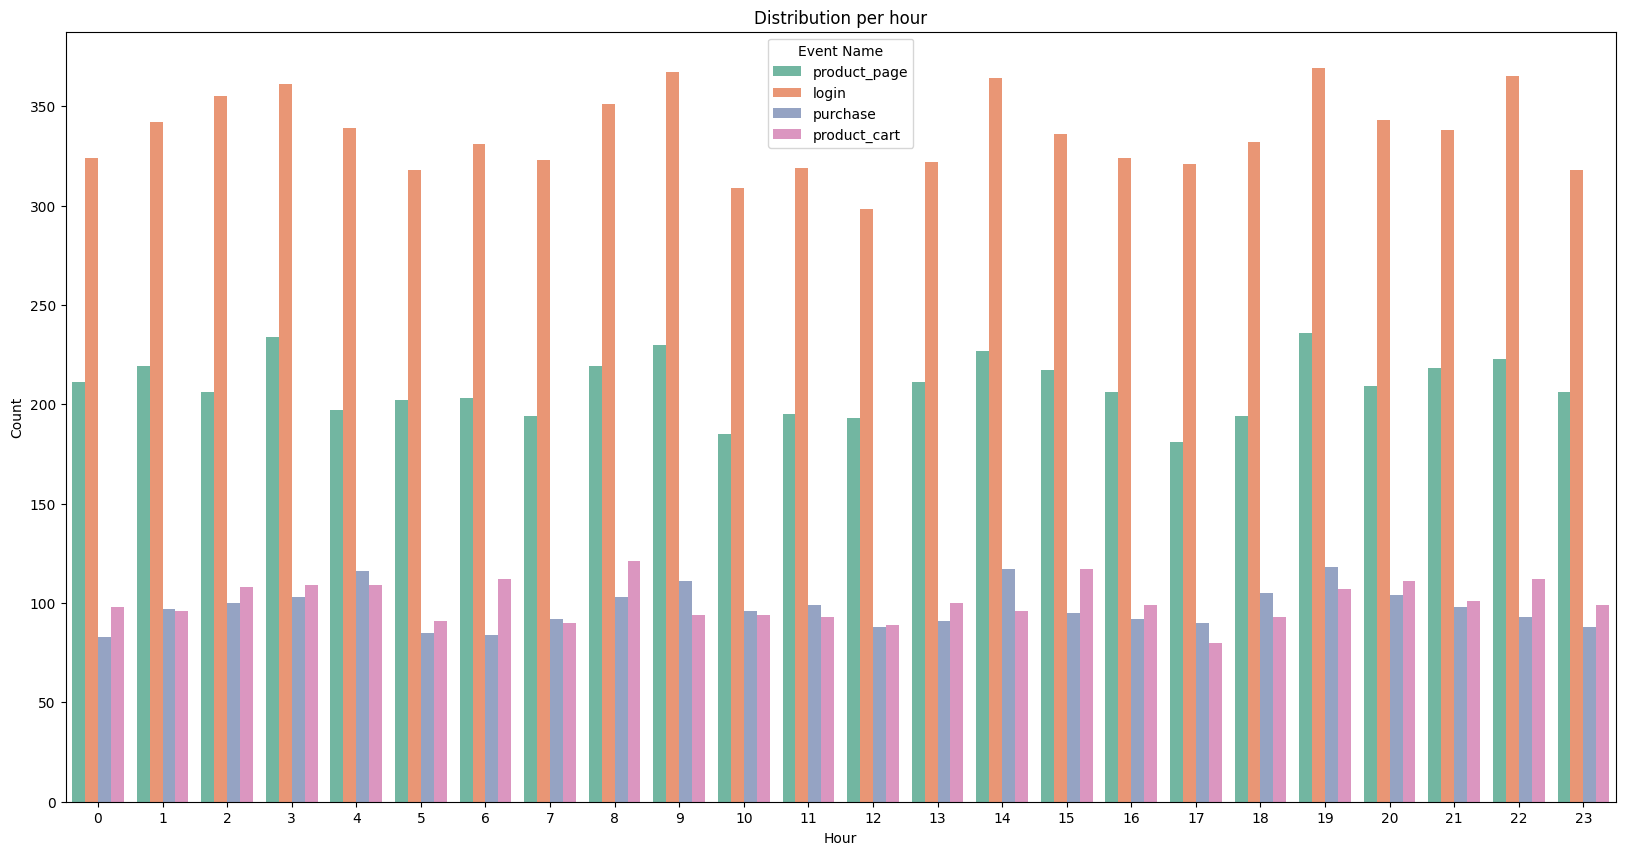

In [41]:
#Distribution by hour
plt.figure(figsize=[20,10])
sns.countplot(data, x='hour', hue='event_name', palette='Set2')
plt.title('Distribution per hour')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(np.arange(0, 24, 1))
plt.legend(title="Event Name")
plt.show()

- There were logins throughout the day, but with emphasis on 9am, 2pm, 7pm and 10pm.
- Users also purchased throughout the day, especially at night and with small peaks at 4am and 2pm as well.

In [42]:
events_per_day = data.groupby(['event_date', 'event_name'])['user_id'].count().reset_index(name='sessions')

events_per_day.sample()

,event_date,event_name,sessions
1,2020-12-07,product_cart,61


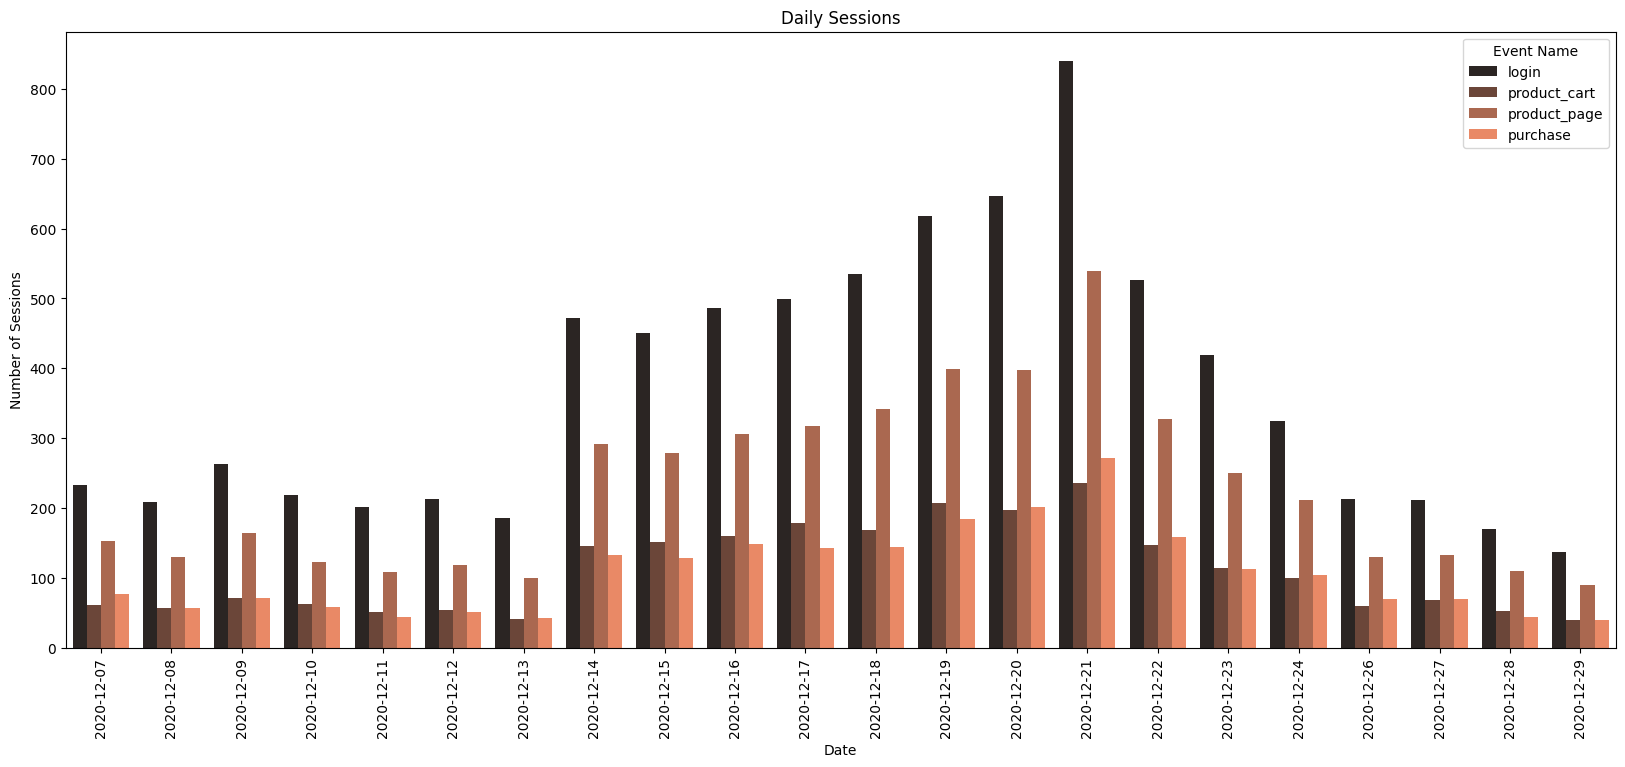

In [43]:
plt.figure(figsize=[20,8])
sns.barplot(events_per_day, x='event_date', hue='event_name', y='sessions', palette='dark:coral')
plt.title('Daily Sessions')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Number of Sessions')
plt.legend(title="Event Name")
plt.show()

- Although the records previously stated that the data went up to 01/01/2021, our data showed movements up to 12/29/2020
- The records began on 07/12 and ended on 12/29
- The date with the most logins and purchases was 12/21, most likely due to Christmas

### Are there any particularities in the data that you should consider before starting A/B testing?

In [45]:
recommender_count = data['user_id'].nunique()

In [46]:
print(f'Total number of users:', recommender_count)

Total number of users: 2788


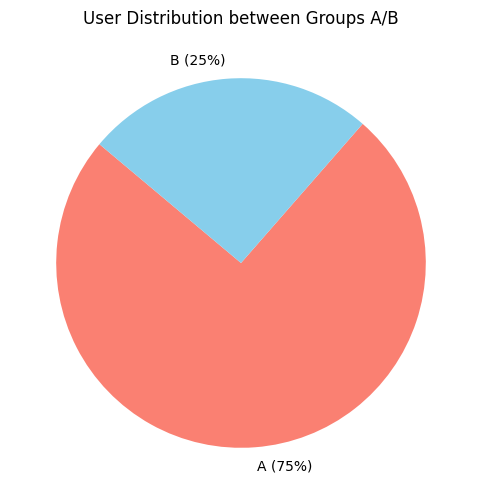

In [48]:
labels = count_group['group']
values = count_group['user_id'].values 

percentages = [v / sum(values) * 100 for v in values]

plt.figure(figsize=(6, 6))
plt.pie(values, labels=[f"{g} ({p:.0f}%)" for g, p in zip(labels, percentages)], startangle=140, colors=colors)

plt.title("User Distribution between Groups A/B")
plt.show()

It is important to note that the test has fewer users than expected to carry it out, in addition, the distribution between users is unbalanced, with 75% in group A and 25% in group B.

## Evaluate A/B test results:

### What can you say about the A/B test results?

- We can see that group B did not perform as well as group A, nor did it have the expected 10% growth in each stage of the funnel. There is a hypothesis that this happens because the groups present a certain imbalance both when we look at each test in isolation, which brings a greater discrepancy, and when we look at the test as a whole. - Despite this, the conversion funnel shows that 30% of users are closing purchases, which can be considered a significant conversion rate
- The number of users who do not continue to the next page after logging in is very high, which may indicate a problem logging in, a confusing website, or an unclear navigation flow dynamic, which may impact the number of sales
- The number of logins remains the same throughout the day, so the time does not have that much of an impact
- The peak of purchases was on 12/21, despite there being a Christmas and New Year's promotion on the 25th. They could consider bringing forward this promotion date, after all, the 25th is when most people are giving gifts and not making purchases

#### Use a z-test to check the statistical difference between the proportions.

Let's define the hypotheses as:

H0: There is a statistical difference between groups A and B <br>
H1: There is no evidence of a difference

In [50]:
def check_hypothesis(group1, group2, event, data, alpha=0.05):
    pivot = data.pivot_table(values='user_id', index='event_name', columns='group', aggfunc='nunique')

    #contagem de usuários únicos que realizaram o evento em cada grupo
    successes = [
        pivot.loc[event, group1] if event in pivot.index and group1 in pivot.columns else 0,
        pivot.loc[event, group2] if event in pivot.index and group2 in pivot.columns else 0
    ]

    #contagem total de usuarios em cada grupo
    trials = [
        data[data.group == group1]['user_id'].nunique(),
        data[data.group == group2]['user_id'].nunique()
    ]

    #executando o teste Z
    z_stat, p_value = proportions_ztest(successes, trials, alternative='two-sided')

    print(f"Event: {event} | p-value: {p_value:.4f}")

    if p_value < alpha:
        print(f"We reject H0 for the event '{event}' between groups {group1} e {group2}.\n")
    else:
        print(f"Failed to reject H0 for event '{event}' between groups {group1} and {group2}.\n")

#testando a hipotese para cada evento
eventos = ['login', 'product_cart', 'product_page', 'purchase']

print("Testing the hypothesis for each event:\n")
for event in eventos:
    check_hypothesis('A', 'B', event, data)

Testing the hypothesis for each event:

Event: login | p-value: 0.0859
Failed to reject H0 for event 'login' between groups A and B.

Event: product_cart | p-value: 0.1766
Failed to reject H0 for event 'product_cart' between groups A and B.

Event: product_page | p-value: 0.0000
We reject H0 for the event 'product_page' between groups A e B.

Event: purchase | p-value: 0.1028
Failed to reject H0 for event 'purchase' between groups A and B.



## Describe your conclusions about the AED step and the result of the A/B test.

- 30% of users completed purchases on the website, although just under half of them did not leave the login page
- The groups were not equally divided, which may have an impact when we analyze the results
- There was a peak in logins and an increase in the number of purchases on December 21st
- The end-of-year promotions could be held before Christmas, taking advantage of the fact that many people give gifts on the 25th
- For the login and shopping cart events, there was no statistical difference between the groups, but for the product page and purchase events, there was a difference
- The test does not seem to have been conducted in the best way, since there is a significant difference between the tests and the groups, which greatly impacts the results
- One recommendation would be to conduct another test to reach more assertive conclusions